## Simulator

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
#import lightning as L 
import pytorch_lightning as pl

import torch
DEVICE = 'GPU'
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1929.26it/s]


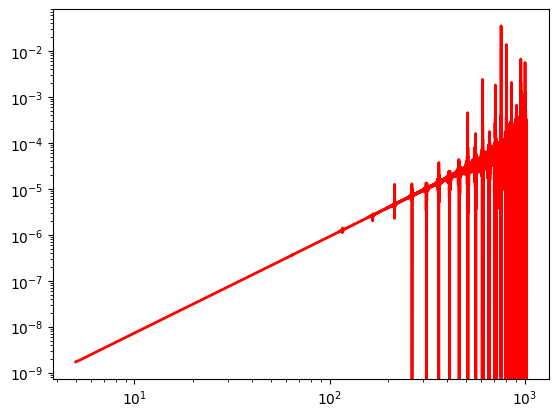

In [27]:
# Simluate data 

fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(10000) # 100 samples

# Plot simulated data
#for i in range(len(samples)):
#    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

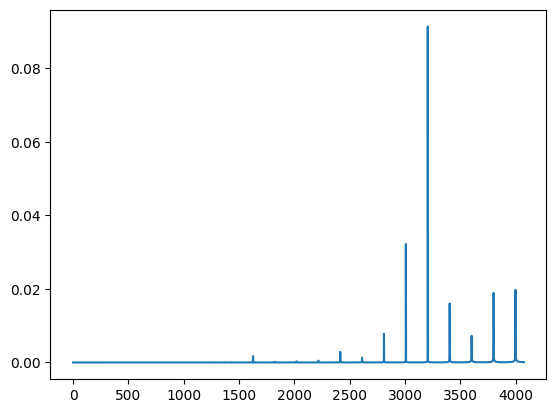

In [3]:
plt.plot(samples[5]['sigma'])

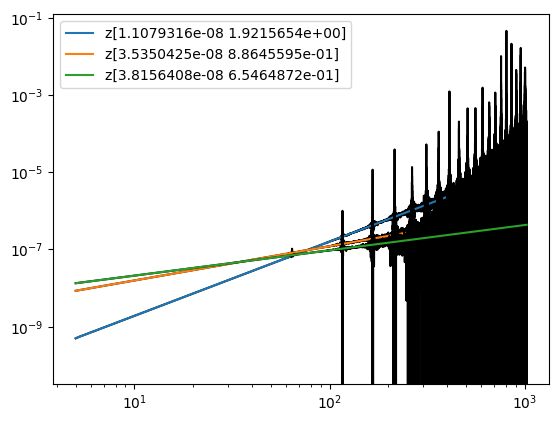

In [4]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
    
# Define UNet

class UNet_Deep(nn.Module):
    def __init__(self):
        super(UNet_Deep, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, padding=4),
            nn.ReLU(),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [6]:
# Deep Net Summary
from torchsummary import summary
model = UNet_Deep()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4076]              64
              ReLU-2             [-1, 16, 4076]               0
         MaxPool1d-3             [-1, 16, 2038]               0
            Conv1d-4             [-1, 32, 2038]           1,568
              ReLU-5             [-1, 32, 2038]               0
         MaxPool1d-6             [-1, 32, 1019]               0
            Conv1d-7             [-1, 64, 1019]           6,208
              ReLU-8             [-1, 64, 1019]               0
         MaxPool1d-9              [-1, 64, 509]               0
           Conv1d-10             [-1, 128, 509]          24,704
             ReLU-11             [-1, 128, 509]               0
        MaxPool1d-12             [-1, 128, 254]               0
           Conv1d-13             [-1, 256, 254]          98,560
             ReLU-14             [-1, 2

Deep UNet gets data down to 63 dimensions

In [7]:
# Pre-Process Data

import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x_samples = samples['x']
m_samples = samples['m']

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_scaled = scaler.fit_transform(x_samples)
m_scaled = scaler.fit_transform(m_samples)

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)



/var/folders/nv/zss1vllj0ng4zcrk888wbjh80000gn/T/ipykernel_1947/3615815013.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [8]:
from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        loss = criterion(outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")

# Evaluation
model.eval()

KeyboardInterrupt: 

In [ ]:
# Evaluation on test set

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1)) 
        test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0210


## Try a Shallower Network

In [28]:

# Define UNet

class UNet_Shallow(nn.Module):
    def __init__(self):
        super(UNet_Shallow, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
            nn.Conv1d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4)
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=4.0445) # is this okay?
            #nn.ConvTranspose1d()

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



model = UNet_Shallow()
summary(model, input_size=(1, 4076))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4076]              64
              ReLU-2             [-1, 16, 4076]               0
         MaxPool1d-3             [-1, 16, 1019]               0
            Conv1d-4             [-1, 64, 1019]           3,136
              ReLU-5             [-1, 64, 1019]               0
         MaxPool1d-6              [-1, 64, 254]               0
            Conv1d-7             [-1, 256, 254]          49,408
              ReLU-8             [-1, 256, 254]               0
         MaxPool1d-9              [-1, 256, 63]               0
           Conv1d-10               [-1, 64, 63]          49,216
             ReLU-11               [-1, 64, 63]               0
         Upsample-12              [-1, 64, 252]               0
           Conv1d-13              [-1, 16, 252]           3,088
             ReLU-14              [-1, 

In [29]:
# Pre-Process Data

import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x_samples = samples['x'] 
m_samples = samples['m']


# Scaling data across each sample (need to transpose first)
transposed_x = x_samples.T
transposed_m = m_samples.T

scaler = StandardScaler()
#scaler = MinMaxScaler()

x_T_scaled = scaler.fit_transform(transposed_x)
m_T_scaled = scaler.fit_transform(transposed_m)

x_scaled = x_T_scaled.T
m_scaled = m_T_scaled.T

x_train, x_test, m_train, m_test = train_test_split(x_scaled, m_scaled, test_size=0.1)

from torch.utils.data import TensorDataset

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
m_train_tensor = torch.tensor(m_train, dtype=torch.float32)
m_test_tensor = torch.tensor(m_test, dtype=torch.float32)

# Define Data Loaders
train_dataset = TensorDataset(x_train_tensor, m_train_tensor)
test_dataset = TensorDataset(x_test_tensor, m_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
x_train_tensor.shape

torch.Size([9000, 4076])

In [31]:
# Check that normalization worked
print("Min: ",np.min(x_scaled[0,:]))
print("Max: ",np.max(x_scaled[0,:]))
print("Mean: ",np.average(x_scaled[0,:]))
print("Var: ", np.var(x_scaled[0,:]))

Min:  -23.561754
Max:  50.842873
Mean:  -1.8717847e-09
Var:  1.0


In [14]:
x_train.shape

(900, 4076)

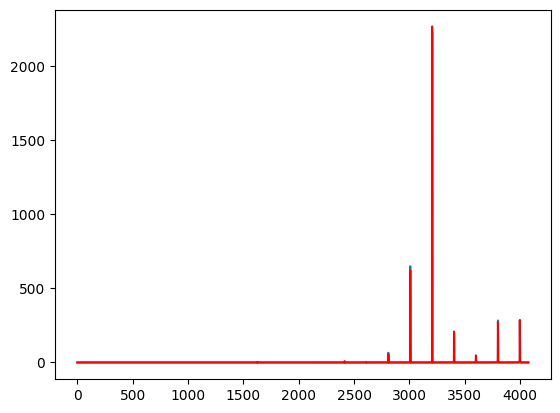

In [32]:
# Getting variance in each dimension of data
def Var_By_Column(data):
    
    sigma = np.zeros(len(data[0,:]))

    for i in range(len(sigma)):
        sigma[i] = np.var(data[:,i])

    return sigma

sig_test = Var_By_Column(x_test)
sig_train = Var_By_Column(x_train)

plt.plot(sig_test)
plt.plot(sig_train, c="r")

In [33]:
# Define weighted loss function
def MSELoss_Weighted(sigma, predictions, targets):
    """""
    Computes the mean squared error (MSE) loss between predictions and targets, 
    weighted by the variance of the dimension
    
    Args:
        predictions (torch.Tensor): The predicted values.
        targets (torch.Tensor): The target values.
        
    Returns:
        torch.Tensor: The computed MSE loss.
    """
    assert predictions.shape == targets.shape, "Shapes of predictions and targets must match"

    sigma = torch.Tensor(sigma)
    
    squared_error = 1/sigma**2 * (predictions - targets)**2 
    
    mse_loss = torch.mean(squared_error)
    
    return mse_loss

Epoch [1/100], Loss: 25615.4768489583
Epoch [2/100], Loss: 20968.7644982639
Epoch [3/100], Loss: 18977.3021440972
Epoch [4/100], Loss: 16999.7734479167
Epoch [5/100], Loss: 15035.0187491319
Epoch [6/100], Loss: 13598.7602413194
Epoch [7/100], Loss: 12925.7926623264
Epoch [8/100], Loss: 12128.0161857639
Epoch [9/100], Loss: 11662.2995711806
Epoch [10/100], Loss: 11272.0369166667
Epoch [11/100], Loss: 10969.5836241319
Epoch [12/100], Loss: 10897.3851562500
Epoch [13/100], Loss: 10666.2344670139
Epoch [14/100], Loss: 10550.3221848958
Epoch [15/100], Loss: 10550.0296753472
Epoch [16/100], Loss: 10350.9064861111
Epoch [17/100], Loss: 10444.0185000000
Epoch [18/100], Loss: 10295.3659557292
Epoch [19/100], Loss: 10086.1326475694
Epoch [20/100], Loss: 10042.0544869792
Epoch [21/100], Loss: 9911.4814314236
Epoch [22/100], Loss: 9932.6602864583
Epoch [23/100], Loss: 9771.9106692708
Epoch [24/100], Loss: 9704.0880182292
Epoch [25/100], Loss: 9821.9315017361
Epoch [26/100], Loss: 9621.2564318576
E

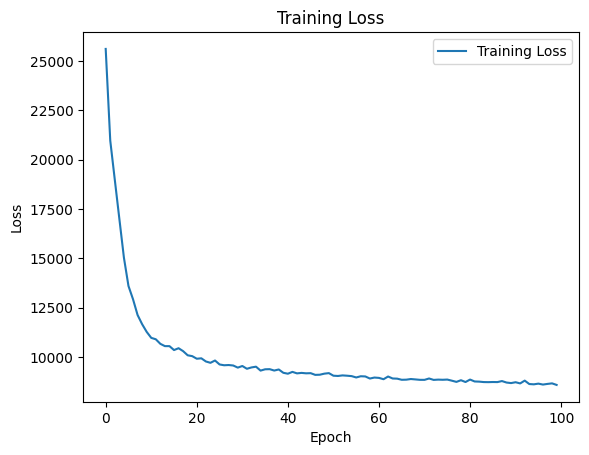

In [34]:
# Define loss function and optimizer
#criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=.0001) # try smaller lr

train_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1)) 
        #loss = criterion(outputs, targets.unsqueeze(1))  
        loss = MSELoss_Weighted(sig_train, outputs, targets.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.10f}")


plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


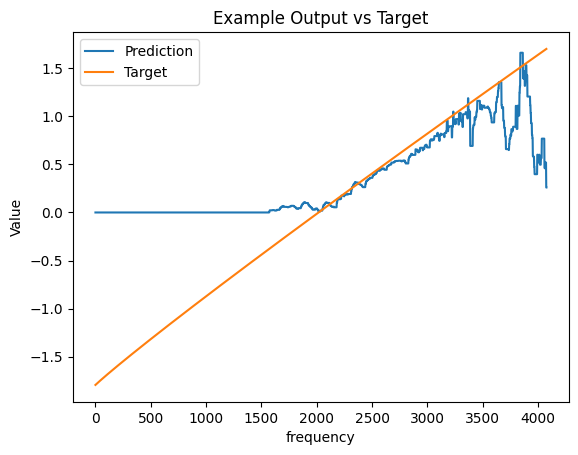

In [38]:
# plotting example output

sample_index = 7  

sample, target = test_dataset[sample_index] 

# Pass the sample through the model to get the prediction
with torch.no_grad():
    model.eval()
    prediction = model(sample.unsqueeze(0).unsqueeze(0)) 
    
# Plot the example output versus its target
plt.plot(prediction.squeeze().numpy(), label='Prediction')
plt.plot(target.numpy(), label='Target')
plt.xlabel('frequency')
plt.ylabel('Value')
plt.title('Example Output vs Target')
plt.legend()
plt.show()

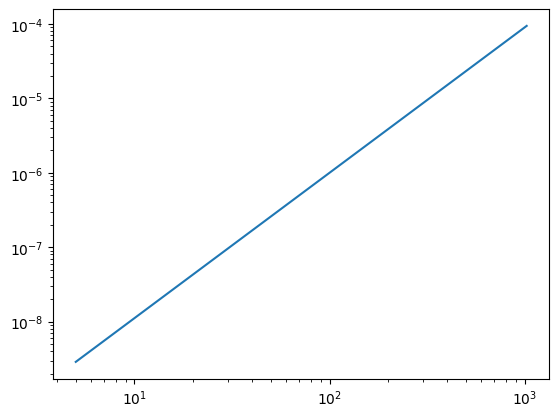

In [36]:
plt.loglog(np.arange(5,1024,0.25),samples['m'][7])

In [26]:
# Evaluation on test set

model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.unsqueeze(1)) 
        #test_loss += criterion(outputs, targets.unsqueeze(1)).item() * inputs.size(0)
        test_loss += MSELoss_Weighted(sig_test,outputs, targets.unsqueeze(1)).item() * inputs.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 61.0815


In [ ]:
# How to extract encoder part example

import torch.nn as nn

class Encoder(nn.Module): # Change to fit our UNet structure
    def __init__(self, in_channels):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

in_channels = 1  
encoder_model = Encoder(in_channels)

# Load the weights of the UNet model and copy them to the encoder model
encoder_model.load_state_dict(model.encoder.state_dict())

# Set the encoder model to evaluation mode
encoder_model.eval()
